<h5 align="center">Metody Obliczeniowe w Nauce i Technice </h5>
<h6 align="center">Labolatorium 13</h6>
<h6 align="center">Minimalizacja funkcji</h6>
<h6 align="center">15 czerwca 2020</h6>

In [19]:
import random
import math
import numpy as np
from scipy.optimize import dual_annealing
import matplotlib.pyplot as plt

<b>Zadanie 1 Problem komiwojażera</b> <br><hr>
Wygeneruj chmurę n losowych punktów w 2D, a następnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów.<br>
* Przedstaw wizualizację otrzymanego rozwiązania dla 3 różnych wartości n oraz 3 różnych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema różnymi grupami parametrów, dziewięć odseparowanych grup punktów).
<br>
* Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap - zamiana kolejności losowej pary połączonych wierzchołków w ścieżce vs. arbitrary swap - zamiana dwóch losowych wierzchołków w ścieżce) oraz początkowej wartości temperatury na zbieżność procesu optymalizacji.
<br>
* Przedstaw wizualizację działania procedury minimalizującej funkcję celu (funkcja przekazana do metody dual annealing może modyfikować zewnątrzny stan)


<b>Funkcje pomcnicze </b>

Funkcja losująca punkty wg. rozkłądu jednostajnego:

In [20]:
def uniform_points(N,x_min,x_max,y_min,y_max):
    X = []
    Y = []
    for _ in range(N):
        X.append(random.uniform(x_min,x_max))
        Y.append(random.uniform(y_min,y_max))

    return X,Y


Funkcja losująca punkty wg. rozkłądu normalnego:

In [21]:
def normal_points(N, mu, sigma):
    X = np.random.normal(mu, sigma, N)
    Y = np.random.normal(mu, sigma, N)
    return X,Y

Funkcja losująca punkty w czterech różnych grupach:

In [22]:
def four_gropus(N,d,x_length,y_length):
    X = []
    Y = []

    for i in range(N):
        if i%4 == 0:
            X.append(random.uniform(0,x_length))
            Y.append(random.uniform(0,y_length))

        if i%4 == 1:
            X.append(random.uniform(x_length+d,2*x_length + d))
            Y.append(random.uniform(y_length+d,2*y_length + d))

        if i%4 == 2:
            X.append(random.uniform(x_length + d, 2*x_length + d))
            Y.append(random.uniform(0,y_length))
        if i%4 == 3:
            X.append(random.uniform(0,x_length))
            Y.append(random.uniform(y_length+d,2*y_length + d))

    return X,Y

Funkcja rysująca droge komiwojażera na wykresie:

In [23]:
def visualize_points(X,Y):
    plt.plot(X,Y)
    plt.plot(X,Y,'ro',markersize=4)
    plt.show()

Funkcja obliczająca długość śćieżki:

In [24]:
def length(X,Y,N):
    leng = 0
    for i in range(N-1):
        leng += math.sqrt((X[i]-X[i+1])**2 + (Y[i] - Y[i+1])**2)
    return leng

<b>Główne funkcje</b>

Funkcja implementująca własy algorytm symulowanego wyżarzania:

In [25]:
def dual_annealing2(f, swap ,N, maxiter=10000, callback = lambda x: None, initial_temp= 100000,cold_speed = 0.98):
    X = [i for i in range(N)]
    Y = [i for i in range(N)]
    B = [i for i in range(N)]
    b_length = 999999999
    Pr = lambda x: math.exp((-1)*x/initial_temp)
    length = 999999999
    for i in range(maxiter):

        swap(X)
        opt = f(X)

        if opt < length:
            Y = [x for x in X]
            length = opt
            if length < b_length:
                b_length = length
                B = [x for x in X]
        else:
            delta_length = math.fabs(opt - length)
            pr = random.uniform(0,1)
            if pr <= Pr(delta_length):
                Y = [x for x in X]
                length = opt

        initial_temp = cold_speed*initial_temp

    return B,b_length

Algorytm wykorzystujący powyższą funkcję:

In [26]:
def salesman(X,Y,N,cons_swap = True, arb_swap = False, temp = 5230):

    def consecutive_swap(x):
        # if cons_swap:
        pair_to_swap = random.randint(0,N-2)
        x[pair_to_swap], x[pair_to_swap + 1] = x[pair_to_swap + 1], x[pair_to_swap]

    def arbitrary_swap(x):
        # if arb_swap:
        node_1 = random.randint(0,N-1)
        node_2 = random.randint(0,N-1)
        while node_2 == node_1:
            node_2 = random.randint(0,N-1)

        x[node_1], x[node_2] = x[node_2], x[node_1]

    def length(x):

        P = x
        leng = 0
        for i in range(N-1):
            leng += math.sqrt((X[P[i]]-X[P[i + 1]])**2 + (Y[P[i]] - Y[P[i+1]])**2)
        return leng

    def adapt_points_to_permutation(P):
        x2 = []
        y2 = []
        for i in range(N):
            y2.append(Y[P[i]])
            x2.append(X[P[i]])
        return x2,y2

    salesman_func = lambda x : length(x)

    if arb_swap:
        ret,leng = dual_annealing2(salesman_func, arbitrary_swap, N,initial_temp=temp)
    if cons_swap:
        ret,leng = dual_annealing2(salesman_func, consecutive_swap, N,initial_temp=temp)

    print(f"Optymalna permutacja: ",ret," \nDługośc ścieżki :", leng)
    return adapt_points_to_permutation(ret)

Funkcja algorytmu symulacyjnego wyżarzania wykorzystująca funkcje biblioteczną:

In [27]:
def salesman_lib(X,Y,N, temp = 5230):

    def permutation(x):
        P = []
        x2_copy = [f for f in x]
        for i in range(N):
            P.append(i)

        x2_ziped = list(zip(P,x2_copy))
        x2_ziped.sort(key=lambda tup: tup[1])
        x2_unziped = list(zip(*x2_ziped))
        x2_copy = x2_unziped[1]
        P = x2_unziped[0]
        return P

    def length(x):
        P = permutation(x)
        leng = 0
        for i in range(N-1):
            leng += math.sqrt((X[P[i]]-X[P[i + 1]])**2 + (Y[P[i]] - Y[P[i+1]])**2)
        return leng

    def adapt_points_to_permutation(P):
        x2 = []
        y2 = []
        for i in range(N):
            y2.append(Y[P[i]])
            x2.append(X[P[i]])
        return x2,y2

    salesman_func = lambda x : length(x)

    lw = [0] * N
    up = [1] * N

    ret = dual_annealing(salesman_func, bounds=list(zip(lw, up)),maxiter=1000,initial_temp=temp)
    print(f"Optymalna permutacja: ",permutation(ret.x)," \nDługośc ścieżki :", ret.fun)
    return adapt_points_to_permutation(permutation(ret.x))


<b> Testowanie</b> <br> Porównanie implemnetacji z funkcji bibliotecznej z autorskiem rozwiązaniem dla różnych sposobów znajdowania sąsiedniego rozwiazania:

* Rozkład jednostajny

Liczba punktów: 10
Wylosowane punkty:


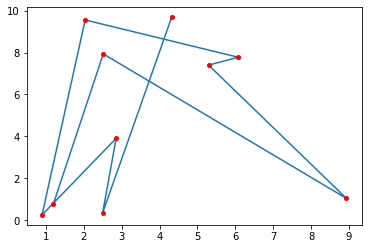

Długośc ścieżki : 55.899604186381396

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (5, 6, 0, 4, 8, 2, 9, 3, 1, 7)  
Długośc ścieżki : 23.581510962108865


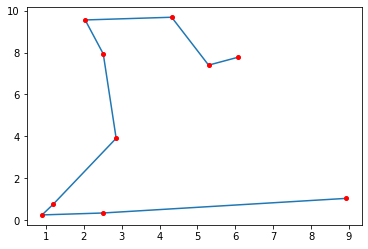


Arbitary swap:
Optymalna permutacja:  [9, 1, 3, 2, 8, 4, 0, 6, 5, 7]  
Długośc ścieżki : 25.788568510341598


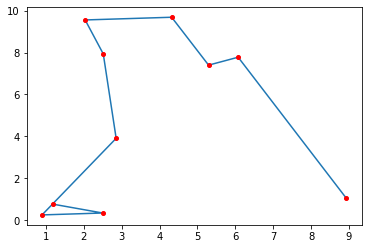


Consecutive wap:
Optymalna permutacja:  [7, 5, 6, 0, 4, 8, 2, 9, 3, 1]  
Długośc ścieżki : 24.420429597398538


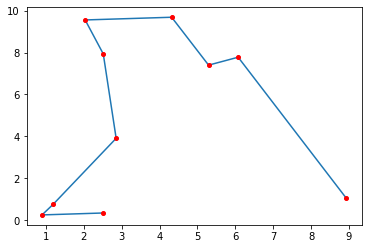

Liczba punktów: 15
Wylosowane punkty:


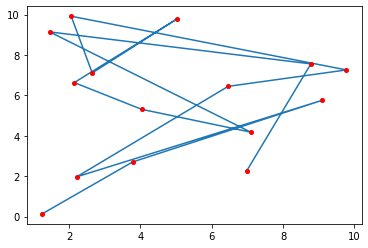

Długośc ścieżki : 72.24982145277626

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (13, 5, 2, 4, 11, 14, 0, 3, 1, 10, 9, 7, 12, 6, 8)  
Długośc ścieżki : 31.569343584635714


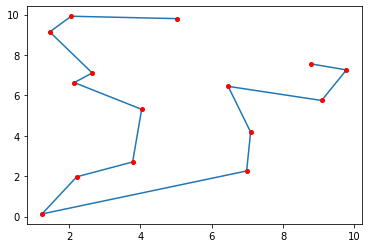


Arbitary swap:
Optymalna permutacja:  [6, 4, 9, 7, 10, 11, 14, 0, 3, 1, 2, 13, 5, 12, 8]  
Długośc ścieżki : 49.17581524602147


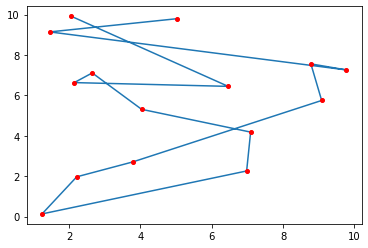


Consecutive wap:
Optymalna permutacja:  [9, 4, 5, 2, 13, 7, 12, 6, 8, 14, 10, 3, 0, 1, 11]  
Długośc ścieżki : 48.860948507054765


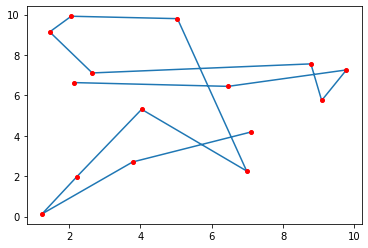

Liczba punktów: 20
Wylosowane punkty:


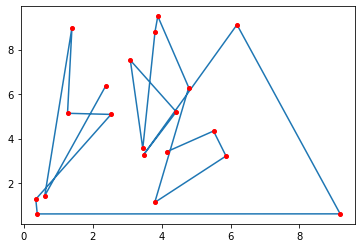

Długośc ścieżki : 76.3753450250802

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (2, 11, 13, 14, 8, 15, 10, 19, 16, 1, 5, 6, 9, 12, 4, 3, 0, 18, 17, 7)  
Długośc ścieżki : 37.53498942109356


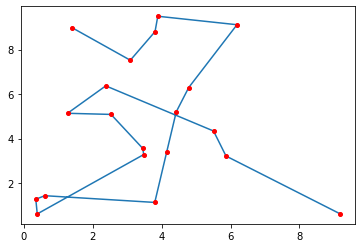


Arbitary swap:
Optymalna permutacja:  [17, 0, 6, 1, 5, 16, 18, 4, 3, 19, 9, 7, 10, 11, 8, 15, 12, 2, 13, 14]  
Długośc ścieżki : 61.605606954773286


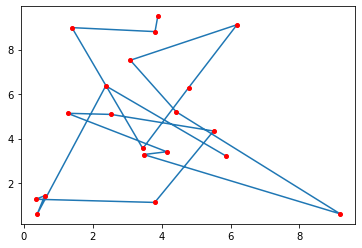


Consecutive wap:
Optymalna permutacja:  [14, 0, 2, 13, 8, 18, 12, 16, 6, 5, 1, 7, 9, 19, 3, 11, 4, 15, 10, 17]  
Długośc ścieżki : 55.61017428794153


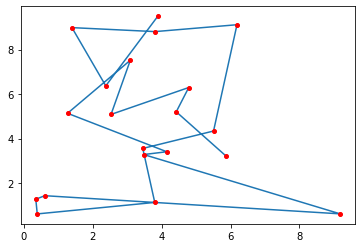

Liczba punktów: 25
Wylosowane punkty:


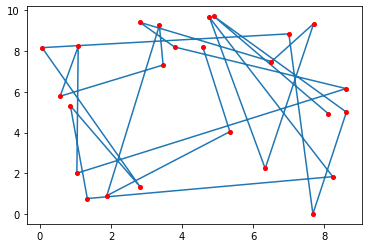

Długośc ścieżki : 132.65025533950035

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (1, 10, 21, 14, 19, 7, 17, 8, 22, 6, 23, 11, 3, 9, 0, 2, 16, 12, 4, 13, 24, 15, 20, 18, 5)  
Długośc ścieżki : 41.25422268551793


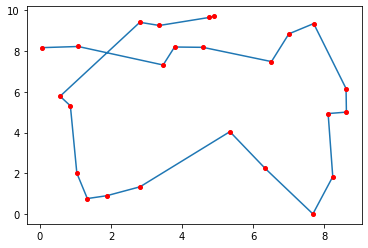


Arbitary swap:
Optymalna permutacja:  [9, 3, 11, 17, 8, 7, 19, 18, 23, 2, 4, 5, 21, 1, 16, 24, 13, 15, 6, 22, 10, 20, 12, 14, 0]  
Długośc ścieżki : 95.3014176549922


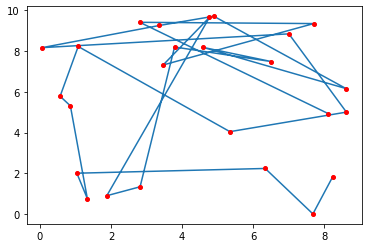


Consecutive wap:
Optymalna permutacja:  [11, 20, 24, 21, 14, 15, 7, 19, 0, 2, 23, 9, 3, 17, 18, 12, 16, 4, 6, 8, 22, 10, 13, 1, 5]  
Długośc ścieżki : 89.7175003712472


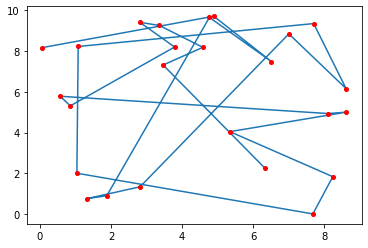

Liczba punktów: 30
Wylosowane punkty:


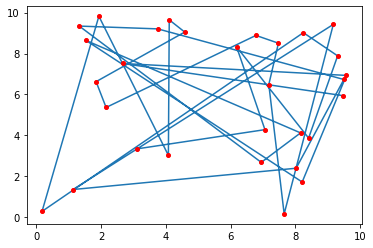

Długośc ścieżki : 163.43251694027364

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (16, 15, 24, 12, 25, 2, 9, 0, 28, 17, 18, 1, 4, 7, 22, 8, 20, 19, 27, 14, 5, 26, 10, 3, 13, 6, 21, 29, 11, 23)  
Długośc ścieżki : 44.492552340057365


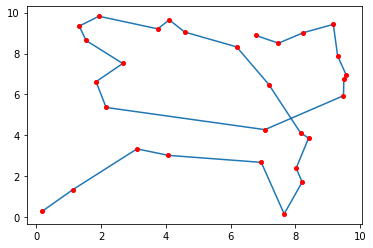


Arbitary swap:
Optymalna permutacja:  [22, 4, 16, 2, 12, 24, 17, 25, 9, 20, 19, 29, 6, 0, 26, 23, 11, 10, 28, 18, 7, 5, 3, 13, 14, 21, 1, 8, 27, 15]  
Długośc ścieżki : 114.66093441164476


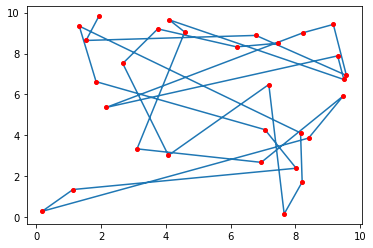


Consecutive wap:
Optymalna permutacja:  [16, 19, 24, 0, 26, 3, 10, 17, 28, 21, 4, 6, 13, 2, 9, 27, 7, 20, 5, 15, 14, 11, 23, 1, 8, 25, 22, 18, 29, 12]  
Długośc ścieżki : 125.7037177648637


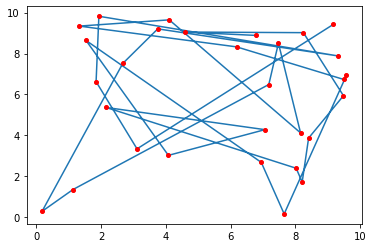

Liczba punktów: 35
Wylosowane punkty:


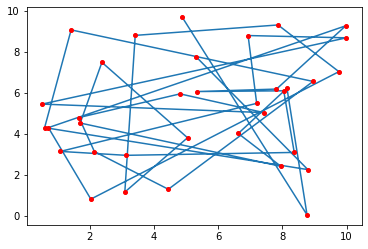

Długośc ścieżki : 172.46791219011027

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (10, 2, 21, 14, 6, 29, 7, 8, 18, 31, 16, 30, 1, 33, 5, 26, 22, 15, 27, 9, 13, 19, 17, 32, 4, 23, 11, 20, 24, 12, 0, 34, 25, 28, 3)  
Długośc ścieżki : 49.71291828036931


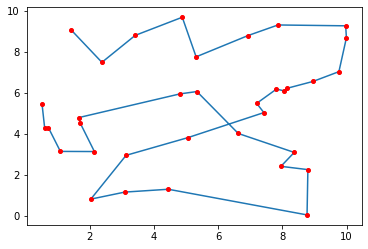


Arbitary swap:
Optymalna permutacja:  [16, 19, 22, 9, 18, 8, 27, 13, 10, 14, 3, 28, 17, 30, 12, 34, 25, 1, 23, 4, 33, 2, 21, 31, 0, 20, 24, 11, 32, 7, 5, 26, 15, 29, 6]  
Długośc ścieżki : 132.40375558495856


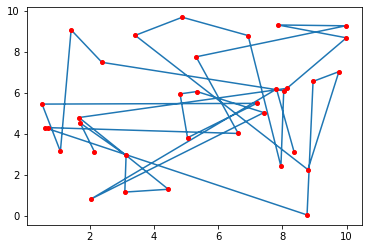


Consecutive wap:
Optymalna permutacja:  [14, 22, 7, 29, 34, 19, 11, 13, 18, 3, 0, 24, 21, 10, 9, 16, 12, 31, 27, 32, 23, 20, 30, 6, 25, 28, 8, 1, 4, 17, 15, 33, 2, 26, 5]  
Długośc ścieżki : 138.89617952921256


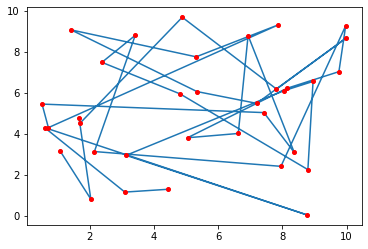

In [39]:
N = 10
for i in range(6):
    print("Liczba punktów:",N)
    print("Wylosowane punkty:")
    X,Y = uniform_points(N,10,0,10,0)
    visualize_points(X,Y)
    print("Długośc ścieżki :", length(X,Y,N))
    print()
    print("Impplementacja z funkcja biblioteczną:")
    X2,Y2 = salesman_lib(X,Y,N)
    visualize_points(X2,Y2)
    print()

    print("Arbitary swap:")
    X2,Y2 = salesman(X,Y,N,arb_swap=True,cons_swap=False)
    visualize_points(X2,Y2)
    print()

    print("Consecutive wap:")
    X2,Y2 = salesman(X,Y,N,arb_swap=False,cons_swap=True)
    visualize_points(X2,Y2)
    N += 5

* Rozkład normalny (1,0)

Liczba punktów: 10
Wylosowane punkty:


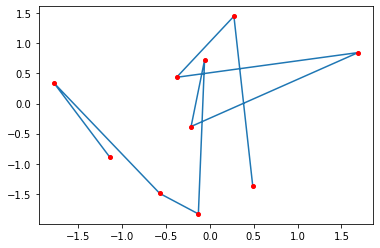

Długośc ścieżki : 16.24487896617187

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (3, 1, 5, 2, 8, 9, 4, 0, 6, 7)  
Długośc ścieżki : 9.168731031711276


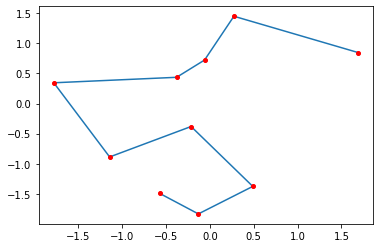


Arbitary swap:
Optymalna permutacja:  [3, 1, 5, 9, 7, 6, 0, 4, 2, 8]  
Długośc ścieżki : 9.902798785836138


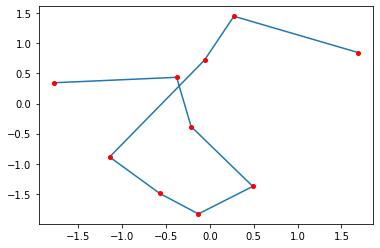


Consecutive swap:
Optymalna permutacja:  [1, 3, 2, 5, 4, 9, 7, 6, 0, 8]  
Długośc ścieżki : 11.267537839354853


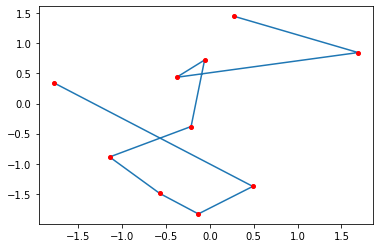

Liczba punktów: 15
Wylosowane punkty:


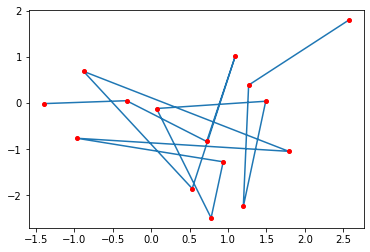

Długośc ścieżki : 30.057745954312058

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (6, 2, 8, 12, 9, 4, 7, 0, 5, 1, 10, 11, 13, 3, 14)  
Długośc ścieżki : 12.766155129629162


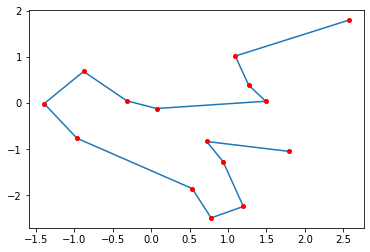


Arbitary swap:
Optymalna permutacja:  [0, 10, 11, 13, 5, 1, 7, 2, 8, 12, 4, 9, 6, 14, 3]  
Długośc ścieżki : 18.366157370919804


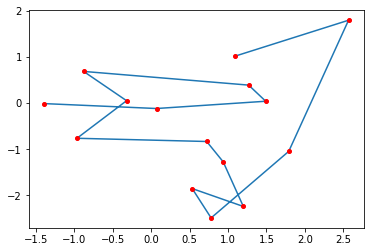


Consecutive swap:
Optymalna permutacja:  [12, 9, 6, 2, 8, 4, 11, 10, 0, 1, 7, 5, 3, 13, 14]  
Długośc ścieżki : 17.680919018854738


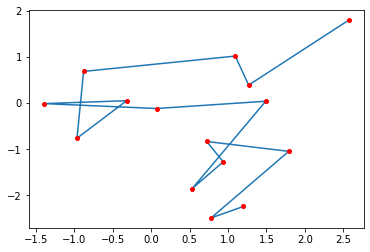

Liczba punktów: 20
Wylosowane punkty:


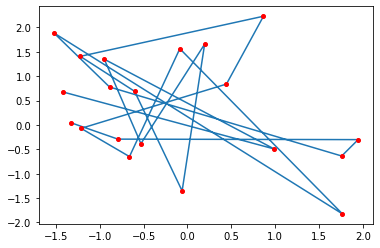

Długośc ścieżki : 40.88175738949369

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (13, 4, 17, 12, 5, 19, 0, 9, 1, 16, 8, 14, 6, 3, 2, 18, 10, 7, 15, 11)  
Długośc ścieżki : 13.655765247056948


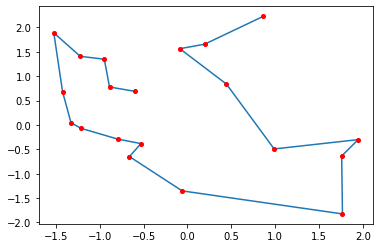


Arbitary swap:
Optymalna permutacja:  [12, 15, 13, 0, 9, 16, 8, 1, 19, 5, 7, 17, 4, 10, 14, 18, 6, 3, 2, 11]  
Długośc ścieżki : 21.34885428118754


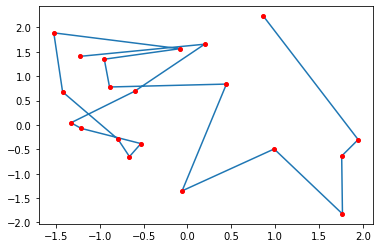


Consecutive swap:
Optymalna permutacja:  [3, 6, 2, 18, 10, 14, 19, 12, 11, 15, 17, 4, 0, 8, 5, 7, 9, 13, 1, 16]  
Długośc ścieżki : 25.658288453249384


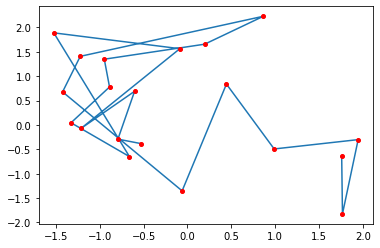

Liczba punktów: 25
Wylosowane punkty:


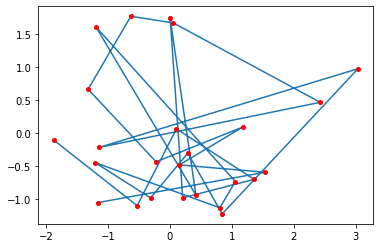

Długośc ścieżki : 47.07175888131189

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (4, 13, 23, 0, 14, 9, 24, 5, 17, 6, 19, 7, 22, 12, 2, 20, 18, 15, 11, 16, 21, 1, 3, 8, 10)  
Długośc ścieżki : 13.650167720417281


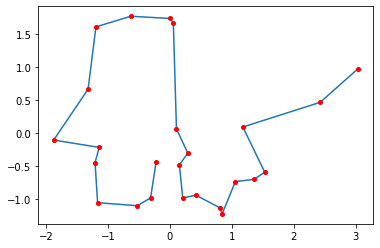


Arbitary swap:
Optymalna permutacja:  [13, 0, 24, 5, 17, 7, 6, 23, 16, 21, 15, 10, 1, 20, 9, 14, 19, 12, 22, 3, 4, 2, 8, 18, 11]  
Długośc ścieżki : 33.152936325011986


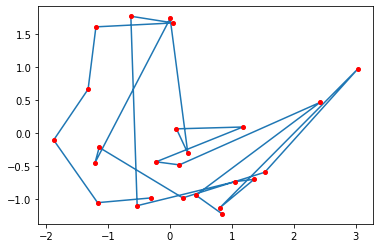


Consecutive swap:
Optymalna permutacja:  [20, 11, 13, 3, 17, 5, 9, 14, 22, 2, 8, 19, 7, 6, 4, 23, 24, 0, 12, 15, 1, 16, 10, 18, 21]  
Długośc ścieżki : 33.221809934235075


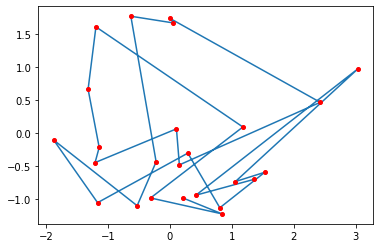

Liczba punktów: 30
Wylosowane punkty:


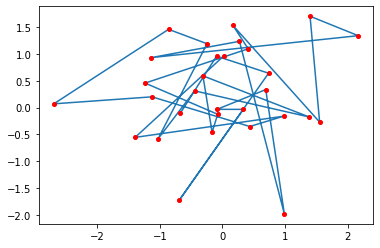

Długośc ścieżki : 46.529862428777484

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (24, 25, 15, 9, 23, 22, 8, 14, 2, 6, 4, 5, 16, 17, 26, 27, 19, 12, 10, 11, 13, 29, 1, 18, 20, 0, 21, 28, 3, 7)  
Długośc ścieżki : 18.07723042859283


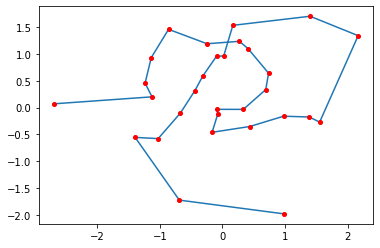


Arbitary swap:
Optymalna permutacja:  [10, 11, 14, 17, 27, 2, 21, 28, 0, 25, 23, 1, 13, 24, 15, 4, 29, 8, 9, 20, 12, 22, 26, 19, 7, 5, 16, 3, 6, 18]  
Długośc ścieżki : 38.96164284549705


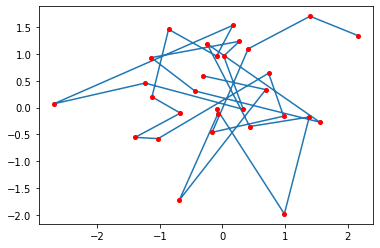


Consecutive swap:
Optymalna permutacja:  [5, 0, 1, 28, 4, 16, 20, 6, 2, 3, 7, 19, 27, 21, 18, 14, 10, 11, 22, 26, 17, 24, 23, 25, 15, 9, 8, 29, 13, 12]  
Długośc ścieżki : 37.24940234138307


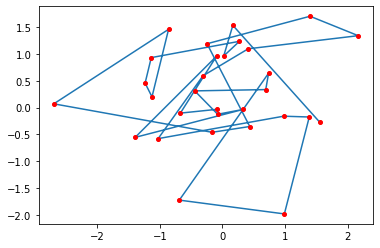

Liczba punktów: 35
Wylosowane punkty:


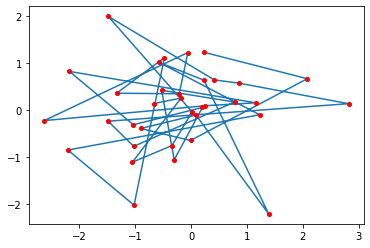

Długośc ścieżki : 61.619909559740364

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (26, 1, 27, 0, 14, 11, 7, 12, 25, 19, 3, 34, 22, 6, 28, 23, 17, 8, 2, 21, 31, 4, 30, 20, 16, 33, 13, 29, 18, 15, 9, 24, 32, 10, 5)  
Długośc ścieżki : 23.292215327293246


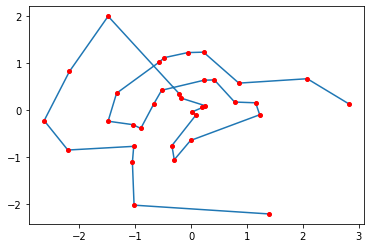


Arbitary swap:
Optymalna permutacja:  [24, 21, 2, 5, 17, 1, 8, 7, 3, 11, 25, 13, 33, 19, 31, 30, 12, 6, 28, 10, 32, 15, 23, 27, 0, 4, 22, 14, 20, 16, 26, 34, 29, 18, 9]  
Długośc ścieżki : 48.05747522561359


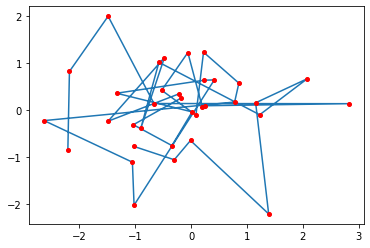


Consecutive swap:
Optymalna permutacja:  [4, 18, 29, 10, 9, 19, 25, 2, 6, 27, 1, 13, 33, 17, 31, 8, 14, 28, 26, 23, 16, 22, 3, 32, 15, 30, 20, 5, 21, 24, 0, 11, 34, 12, 7]  
Długośc ścieżki : 49.079818445528566


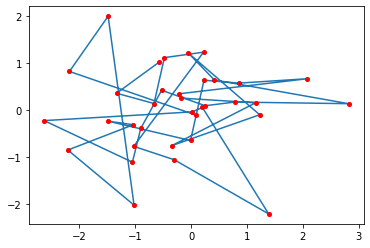

In [40]:
N = 10
for i in range(6):
    print("Liczba punktów:",N)
    print("Wylosowane punkty:")
    X,Y = normal_points(N,0,1)
    visualize_points(X,Y)
    print("Długośc ścieżki :", length(X,Y,N))
    print()

    print("Impplementacja z funkcja biblioteczną:")
    X2,Y2 = salesman_lib(X,Y,N)
    visualize_points(X2,Y2)
    print()

    print("Arbitary swap:")
    X2,Y2 = salesman(X,Y,N,arb_swap=True,cons_swap=False)
    visualize_points(X2,Y2)
    print()

    print("Consecutive swap:")
    X2,Y2 = salesman(X,Y,N,arb_swap=False,cons_swap=True)
    visualize_points(X2,Y2)
    N += 5

* Cztery grupy punktów:

Liczba punktów: 10
Wylosowane punkty:


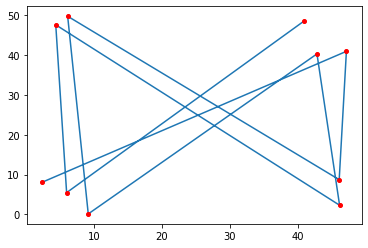

Długośc ścieżki : 445.17452141612455

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (3, 7, 0, 8, 4, 6, 2, 1, 5, 9)  
Długośc ścieżki : 141.79475120385044


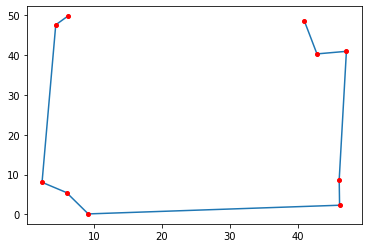


Arbitary swap:
Optymalna permutacja:  [0, 8, 4, 6, 2, 1, 5, 9, 3, 7]  
Długośc ścieżki : 137.05637001830107


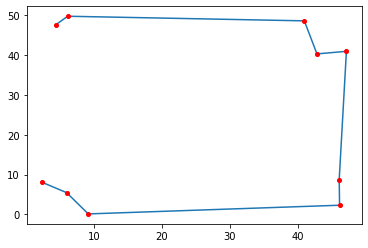


Consecutive wap:
Optymalna permutacja:  [1, 9, 5, 6, 2, 0, 8, 4, 3, 7]  
Długośc ścieżki : 170.00517141803402


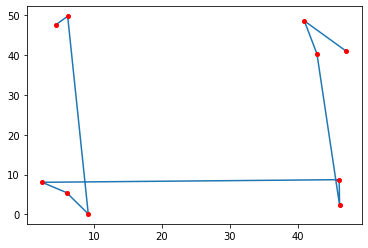

Liczba punktów: 15
Wylosowane punkty:


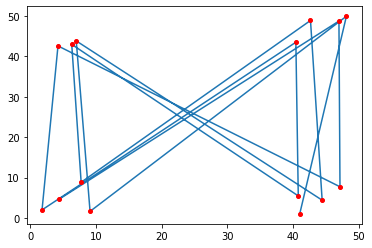

Długośc ścieżki : 683.3766538235965

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (8, 0, 4, 12, 14, 6, 10, 2, 3, 7, 11, 5, 9, 1, 13)  
Długośc ścieżki : 164.49712743785958


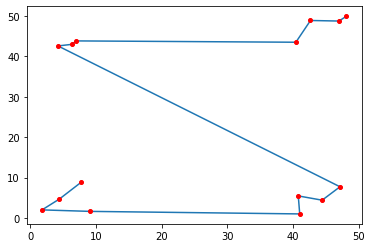


Arbitary swap:
Optymalna permutacja:  [3, 7, 8, 4, 12, 0, 14, 6, 9, 13, 1, 5, 11, 10, 2]  
Długośc ścieżki : 250.44437471954868


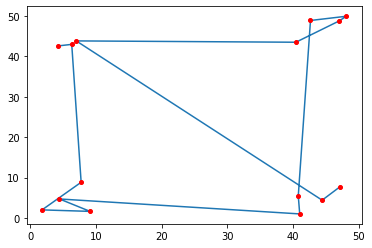


Consecutive wap:
Optymalna permutacja:  [3, 11, 7, 5, 2, 4, 0, 12, 14, 6, 10, 8, 9, 13, 1]  
Długośc ścieżki : 267.01401175295393


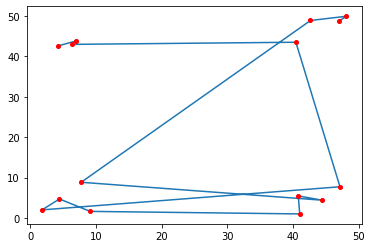

Liczba punktów: 20
Wylosowane punkty:


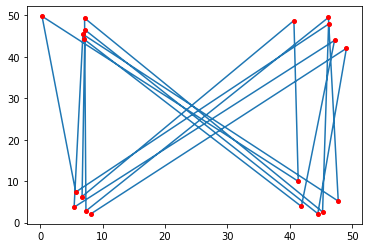

Długośc ścieżki : 953.8366598999529

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (16, 12, 0, 18, 2, 10, 14, 6, 1, 17, 19, 15, 3, 11, 7, 8, 4, 5, 13, 9)  
Długośc ścieżki : 246.19091816102366


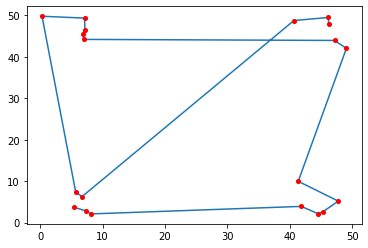


Arbitary swap:
Optymalna permutacja:  [8, 12, 0, 16, 19, 3, 1, 13, 9, 15, 7, 4, 11, 14, 5, 17, 2, 6, 10, 18]  
Długośc ścieżki : 412.3715797600245


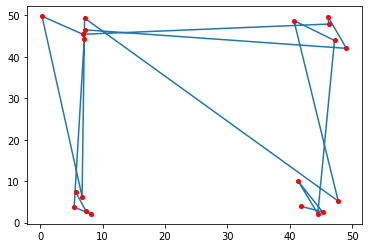


Consecutive wap:
Optymalna permutacja:  [9, 13, 6, 4, 12, 0, 15, 3, 1, 17, 2, 5, 11, 7, 19, 16, 18, 10, 14, 8]  
Długośc ścieżki : 434.17854523489666


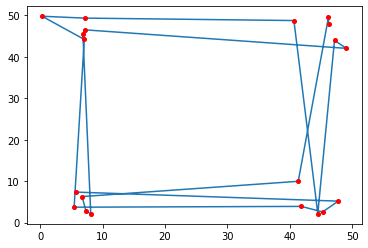

Liczba punktów: 25
Wylosowane punkty:


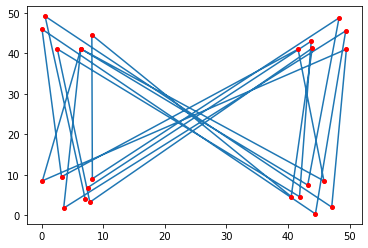

Długośc ścieżki : 1131.4716551182048

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (18, 10, 3, 15, 23, 7, 2, 22, 14, 6, 19, 11, 16, 20, 12, 4, 24, 0, 8, 17, 5, 1, 9, 13, 21)  
Długośc ścieżki : 309.2199261109899


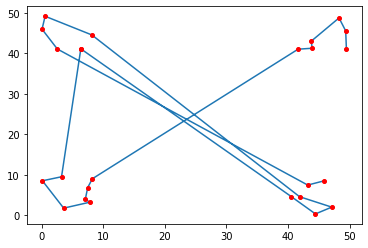


Arbitary swap:
Optymalna permutacja:  [8, 20, 18, 2, 22, 10, 6, 13, 14, 0, 12, 16, 4, 17, 1, 23, 11, 3, 5, 9, 24, 15, 19, 7, 21]  
Długośc ścieżki : 540.5893775150926


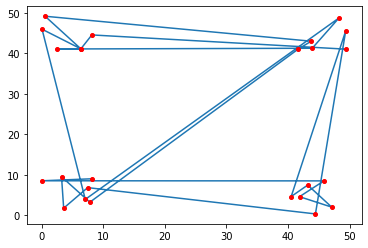


Consecutive wap:
Optymalna permutacja:  [19, 7, 3, 1, 18, 8, 12, 16, 0, 23, 9, 4, 2, 24, 20, 11, 22, 6, 15, 13, 5, 17, 21, 10, 14]  
Długośc ścieżki : 636.4744797039517


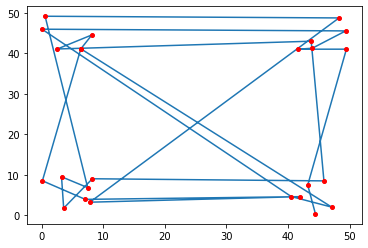

Liczba punktów: 30
Wylosowane punkty:


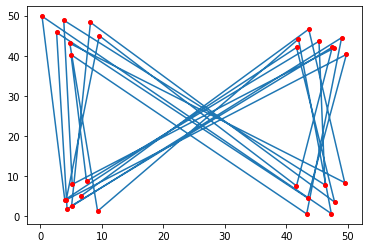

Długośc ścieżki : 1419.6201929011777

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (17, 29, 13, 21, 25, 1, 5, 9, 2, 26, 18, 22, 6, 10, 14, 4, 12, 20, 8, 16, 0, 28, 24, 23, 3, 15, 11, 27, 19, 7)  
Długośc ścieżki : 183.57276543486512


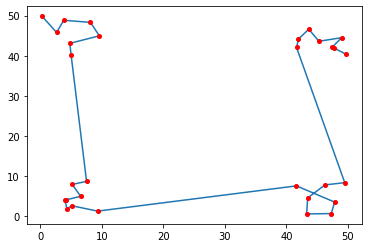


Arbitary swap:
Optymalna permutacja:  [21, 20, 0, 12, 26, 22, 24, 16, 4, 8, 3, 7, 23, 11, 14, 5, 13, 28, 27, 9, 25, 1, 18, 2, 15, 19, 17, 29, 10, 6]  
Długośc ścieżki : 677.0670717476067


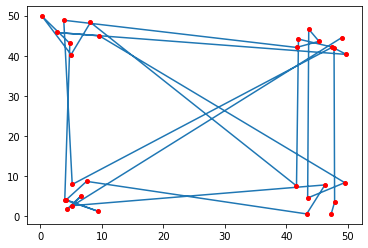


Consecutive wap:
Optymalna permutacja:  [0, 4, 2, 22, 6, 24, 15, 21, 27, 11, 8, 16, 3, 1, 9, 25, 14, 13, 26, 10, 19, 29, 5, 18, 17, 20, 12, 28, 7, 23]  
Długośc ścieżki : 776.2427744324182


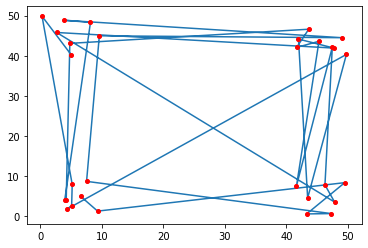

Liczba punktów: 35
Wylosowane punkty:


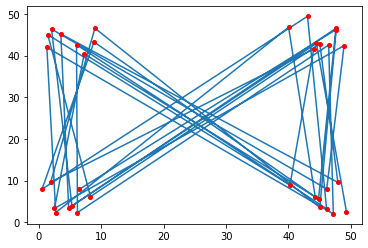

Długośc ścieżki : 1625.2239149391621

Impplementacja z funkcja biblioteczną:
Optymalna permutacja:  (34, 10, 6, 22, 2, 14, 26, 18, 30, 17, 1, 21, 5, 13, 24, 4, 16, 12, 32, 20, 8, 28, 0, 25, 9, 29, 33, 23, 3, 15, 7, 11, 27, 19, 31)  
Długośc ścieżki : 252.02856386632246


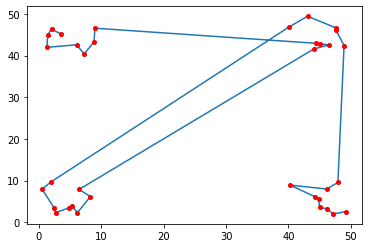


Arbitary swap:
Optymalna permutacja:  [3, 5, 30, 14, 22, 26, 23, 0, 2, 6, 20, 31, 24, 32, 28, 16, 12, 8, 34, 9, 13, 18, 27, 11, 19, 7, 4, 29, 33, 25, 17, 21, 1, 15, 10]  
Długośc ścieżki : 759.3705099074026


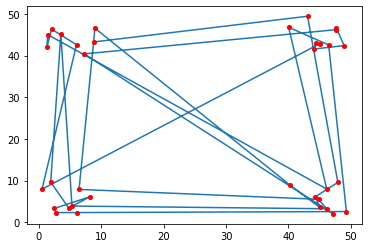


Consecutive wap:
Optymalna permutacja:  [21, 23, 15, 11, 18, 10, 5, 28, 6, 33, 29, 22, 2, 25, 27, 24, 8, 31, 4, 13, 17, 1, 9, 14, 34, 0, 7, 3, 19, 16, 12, 20, 30, 26, 32]  
Długośc ścieżki : 877.2139818823179


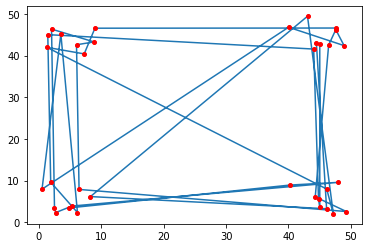

In [41]:
N = 10
for i in range(6):
    print("Liczba punktów:",N)
    print("Wylosowane punkty:")
    X,Y = four_gropus(N,30,10,10)
    visualize_points(X,Y)
    print("Długośc ścieżki :", length(X,Y,N))
    print()

    print("Impplementacja z funkcja biblioteczną:")
    X2,Y2 = salesman_lib(X,Y,N)
    visualize_points(X2,Y2)
    print()

    print("Arbitary swap:")
    X2,Y2 = salesman(X,Y,N,arb_swap=True,cons_swap=False)
    visualize_points(X2,Y2)
    print()

    print("Consecutive wap:")
    X2,Y2 = salesman(X,Y,N,arb_swap=False,cons_swap=True)
    visualize_points(X2,Y2)
    N += 5

<b>Wnioski:</b>

* Funkcja bilbioteczna wypada o wiele lepiej w porównaniu do mojej własnej funkcji, ale jej złożoność jest więszka liczy się o wiele dłużej ze względu na potrzebe dostasowania "bounds" do problemu komiwojadżera.
* Porównując consecutive swap, oraz arbitary swap doszedłem do wniosku, że podane sposoby wypadają podobnie, jednak consecutive swap wypada lepiej dla rozkłądu jednostajnego, natomiast arbitary swap dla minimalnie lepiej dla rozkłądu normalnego, oraz sporo lepiej dla czterch grup punktów.

Wpływ temperatury:

Dla temperatury: 0.0001
Optymalna permutacja:  (14, 10, 4, 6, 19, 8, 7, 1, 0, 5, 2, 15, 17, 12, 18, 11, 13, 9, 16, 3)  
Długośc ścieżki : 17.199244723112386


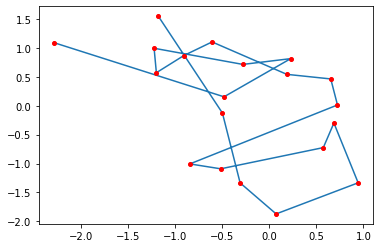

Dla temperatury: 0.001
Optymalna permutacja:  (16, 10, 5, 8, 7, 14, 11, 15, 2, 9, 17, 19, 6, 4, 1, 0, 13, 12, 18, 3)  
Długośc ścieżki : 18.382708499929752


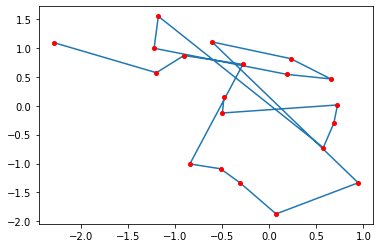

Dla temperatury: 0.01
Optymalna permutacja:  (1, 4, 6, 19, 8, 13, 12, 17, 18, 0, 10, 16, 7, 5, 2, 15, 9, 11, 14, 3)  
Długośc ścieżki : 15.67689625163316


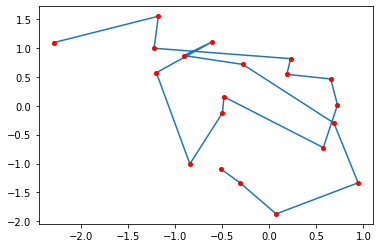

Dla temperatury: 0.1
Optymalna permutacja:  (19, 6, 4, 1, 0, 10, 16, 7, 8, 5, 2, 15, 9, 13, 17, 12, 14, 11, 18, 3)  
Długośc ścieżki : 11.219679408519074


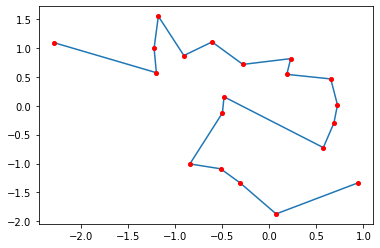

Dla temperatury: 1.0
Optymalna permutacja:  (2, 5, 8, 7, 19, 6, 4, 1, 0, 10, 16, 18, 11, 12, 13, 15, 9, 17, 14, 3)  
Długośc ścieżki : 11.305705660920164


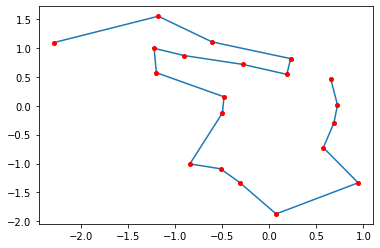

Dla temperatury: 10.0
Optymalna permutacja:  (19, 6, 4, 1, 0, 18, 11, 12, 16, 10, 7, 8, 5, 2, 15, 9, 13, 17, 14, 3)  
Długośc ścieżki : 11.965741387716262


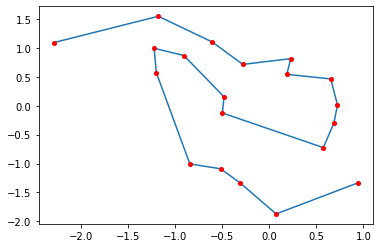

Dla temperatury: 100.0
Optymalna permutacja:  (10, 16, 18, 12, 11, 3, 14, 17, 13, 9, 15, 2, 5, 8, 0, 1, 4, 6, 19, 7)  
Długośc ścieżki : 12.141984731792412


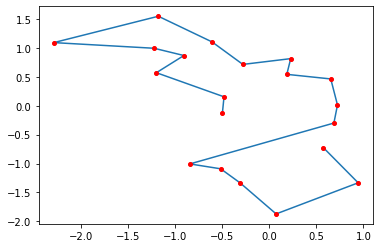

Dla temperatury: 1000.0
Optymalna permutacja:  (19, 7, 8, 5, 2, 15, 9, 13, 12, 18, 11, 3, 14, 17, 16, 10, 0, 1, 4, 6)  
Długośc ścieżki : 11.165060153255435


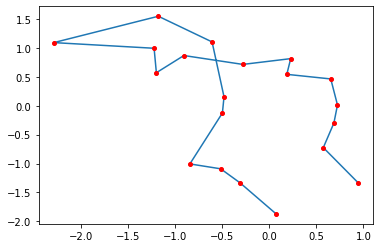

Dla temperatury: 10000.0
Optymalna permutacja:  (19, 6, 4, 1, 0, 10, 16, 7, 8, 5, 2, 15, 9, 13, 17, 14, 11, 12, 18, 3)  
Długośc ścieżki : 11.164466968993727


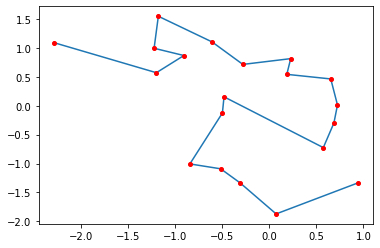

Dla temperatury: 100000.0
Optymalna permutacja:  (0, 1, 4, 6, 19, 7, 8, 5, 2, 15, 9, 13, 12, 11, 14, 17, 16, 10, 18, 3)  
Długośc ścieżki : 11.224502958949714


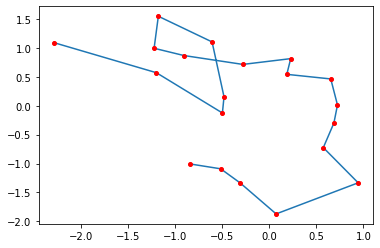

Dla temperatury: 1000000.0
Optymalna permutacja:  (2, 15, 16, 10, 0, 1, 4, 6, 19, 7, 8, 5, 9, 13, 17, 14, 11, 12, 18, 3)  
Długośc ścieżki : 11.488407064791225


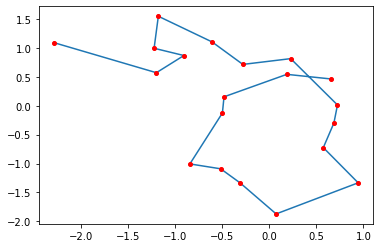

Dla temperatury: 10000000.0
Optymalna permutacja:  (17, 13, 9, 15, 2, 5, 8, 7, 19, 6, 4, 1, 0, 10, 16, 18, 12, 11, 14, 3)  
Długośc ścieżki : 10.604735849364559


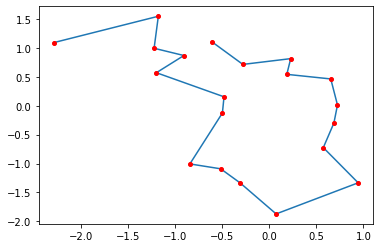

Dla temperatury: 100000000.0
Optymalna permutacja:  (16, 10, 0, 1, 4, 6, 19, 7, 8, 5, 2, 15, 9, 13, 17, 12, 18, 11, 14, 3)  
Długośc ścieżki : 10.237857946503663


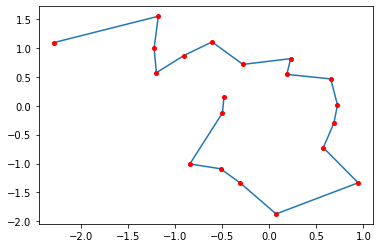

Dla temperatury: 1000000000.0
Optymalna permutacja:  (3, 18, 0, 1, 4, 6, 19, 7, 10, 16, 12, 11, 14, 17, 13, 9, 15, 2, 5, 8)  
Długośc ścieżki : 12.378266953614094


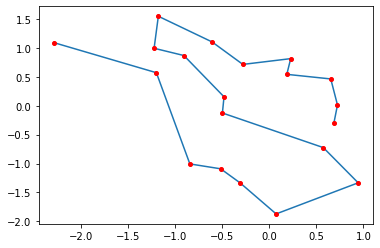

Dla temperatury: 10000000000.0
Optymalna permutacja:  (13, 17, 14, 3, 11, 12, 18, 0, 1, 4, 10, 16, 15, 9, 2, 5, 8, 7, 19, 6)  
Długośc ścieżki : 12.578854491297312


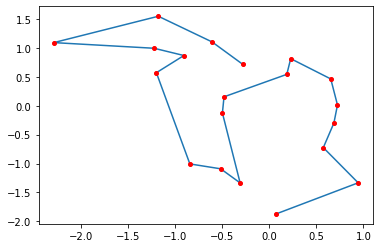

Dla temperatury: 100000000000.0
Optymalna permutacja:  (19, 7, 16, 10, 0, 1, 4, 6, 8, 5, 2, 15, 9, 13, 17, 14, 11, 12, 18, 3)  
Długośc ścieżki : 12.100403268074203


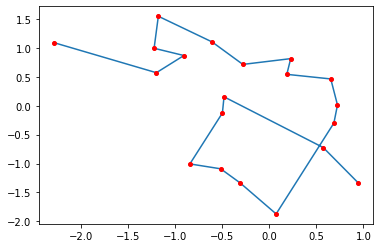

Dla temperatury: 1000000000000.0
Optymalna permutacja:  (3, 18, 12, 11, 14, 17, 13, 9, 15, 2, 5, 8, 7, 19, 6, 4, 1, 0, 10, 16)  
Długośc ścieżki : 10.504520224860698


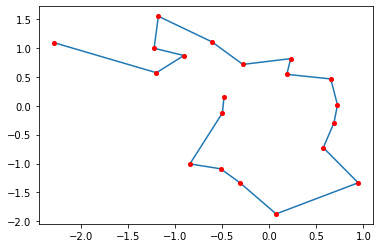

Dla temperatury: 10000000000000.0
Optymalna permutacja:  (10, 16, 12, 17, 13, 9, 15, 2, 5, 8, 7, 19, 6, 4, 1, 0, 18, 11, 14, 3)  
Długośc ścieżki : 11.32325884412571


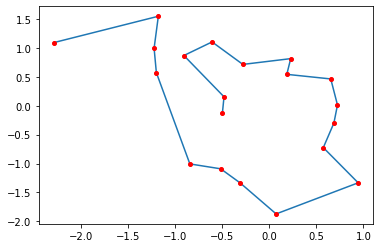

Dla temperatury: 100000000000000.0
Optymalna permutacja:  (3, 18, 16, 10, 7, 8, 5, 2, 15, 9, 13, 17, 14, 11, 12, 0, 1, 4, 6, 19)  
Długośc ścieżki : 12.362683875727988


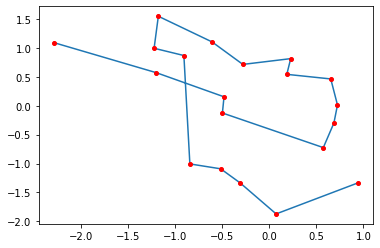

Dla temperatury: 1000000000000000.0
Optymalna permutacja:  (0, 1, 4, 6, 19, 7, 8, 5, 10, 16, 18, 3, 14, 11, 12, 17, 13, 9, 15, 2)  
Długośc ścieżki : 11.604481425938882


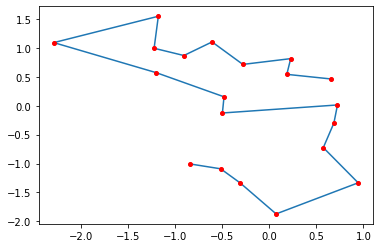

In [35]:
N = 20
X,Y = normal_points(N,0,1)
start_temp = 0.0001
for i in range(20):
    print("Dla temperatury:",start_temp)
    X2,Y2 = salesman_lib(X,Y,N,temp=start_temp)
    visualize_points(X2,Y2)
    start_temp = start_temp*10

<b> Wnioski </b>

* Dla niskiej początkowej temperatury wyniki są gorsze, jest to związane z tym, że przy niskim T, prawdopodobienstwo wybrania gorszego rozwiażania jest tak niskie, że algorytm staje się podobny do metod iteracyjnych.
* Lepsze rozwiązania uzyskujemy dla wyższych temperatur, jest to związane z tym, że prawdopodobieństwo wyboru gorszego rozwiązania, a tym samym natrafienia na potencjalnie lepsze (nie utkiemy w minimum lokalnym) zwiększa się. To jest całe clue tego algorytmu.

<b>Wizualizacja</b>

Funkcja wizualizująca przebieg algorytmu: (została dodana funkcja callback przy znjadowaniu minimum, która wyświetla wykres)

In [37]:
def salesman_visualize(X,Y,N,no_swap = True,cons_swap = False, arb_swap = False, temp = None ):

    def permutation(x):
        P = []
        x2_copy = [f for f in x]
        for i in range(N):
            P.append(i)

        x2_ziped = list(zip(P,x2_copy))
        x2_ziped.sort(key=lambda tup: tup[1])
        x2_unziped = list(zip(*x2_ziped))
        x2_copy = x2_unziped[1]
        P = x2_unziped[0]
        return P

    def consecutive_swap(x):
        if cons_swap:
            pair_to_swap = random.randint(0,N-2)
            x[pair_to_swap], x[pair_to_swap + 1] = x[pair_to_swap + 1], x[pair_to_swap]

    def arbitrary_swap(x):
        if arb_swap:
            node_1 = random.randint(0,N-1)
            node_2 = random.randint(0,N-1)
            while node_2 == node_1:
                node_2 = random.randint(0,N-1)

            x[node_1], x[node_2] = x[node_2], x[node_1]

    def length(x):

        consecutive_swap(x)
        arbitrary_swap(x)

        P = permutation(x)
        leng = 0
        for i in range(N-1):
            leng += math.sqrt((X[P[i]]-X[P[i + 1]])**2 + (Y[P[i]] - Y[P[i+1]])**2)
        return leng

    def adapt_points_to_permutation(P):
        x2 = []
        y2 = []
        for i in range(N):
            y2.append(Y[P[i]])
            x2.append(X[P[i]])
        return x2,y2

    def callback(x,y, context):
        x_plt,y_plt = adapt_points_to_permutation(permutation(x))
        visualize_points(x_plt,y_plt)

    salesman_func = lambda x : length(x)

    lw = [0] * N
    up = [1] * N
    ret = dual_annealing(salesman_func, bounds=list(zip(lw, up)),maxiter=1000,callback=callback)
    print(f"Optymalna permutacja: ",permutation(ret.x)," \nDługośc ścieżki :", ret.fun)
    return adapt_points_to_permutation(permutation(ret.x))


Przykładowa wizualizacja:

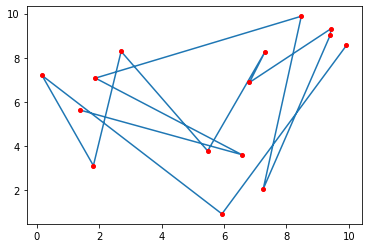

Długośc ścieżki : 75.91888520572546


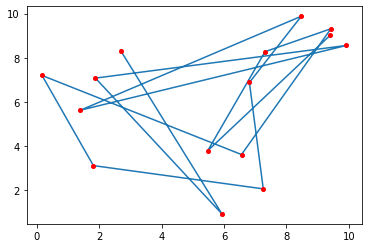

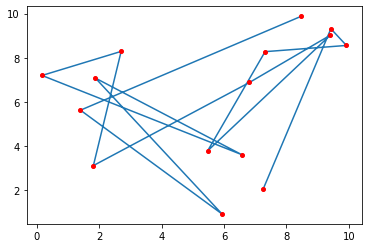

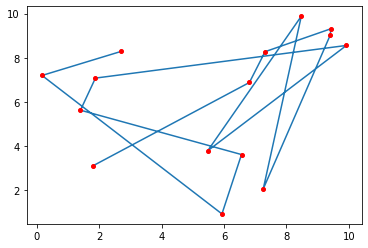

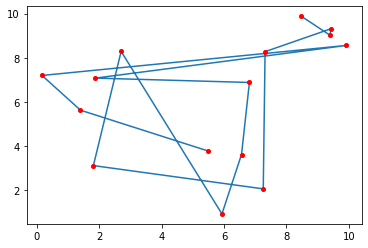

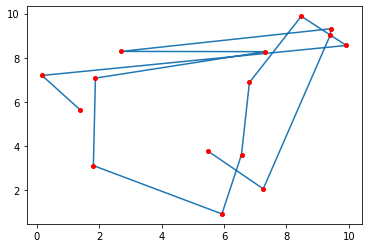

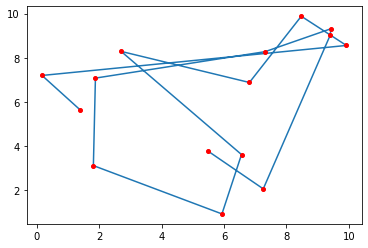

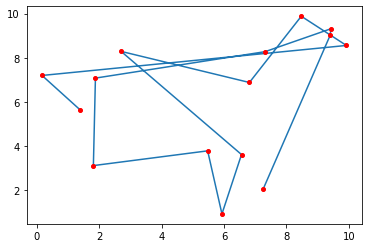

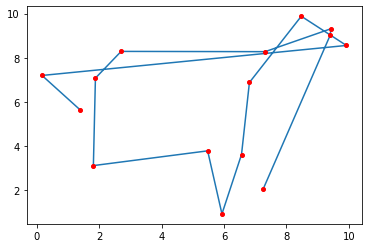

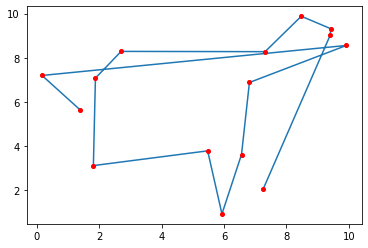

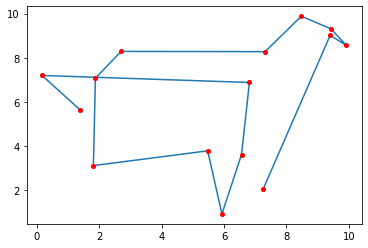

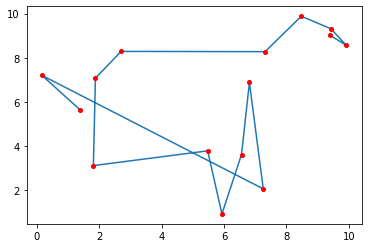

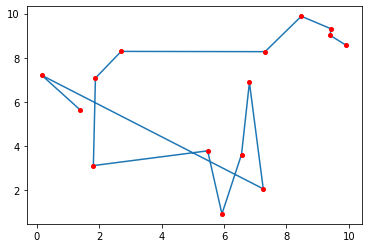

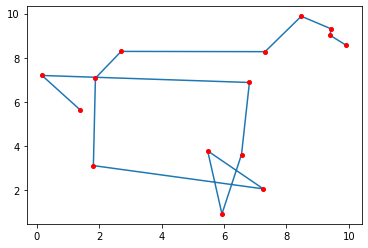

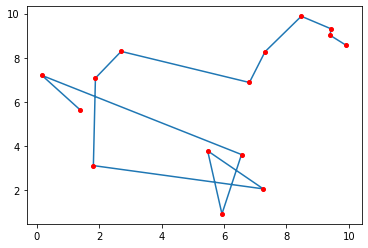

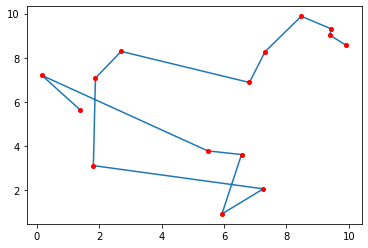

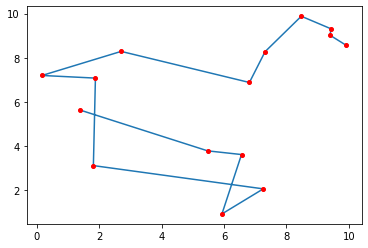

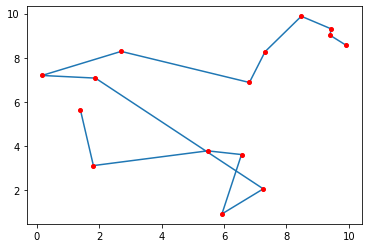

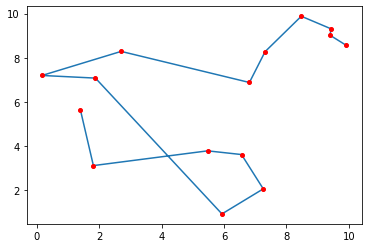

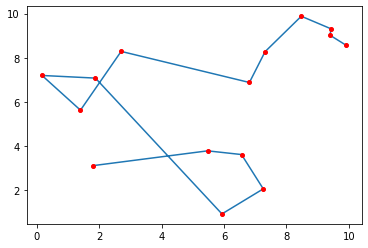

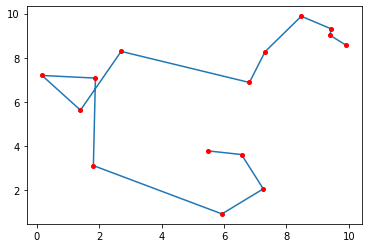

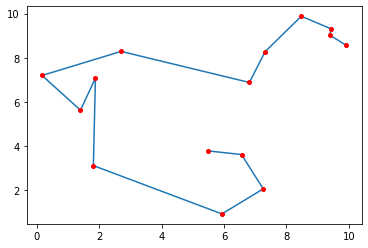

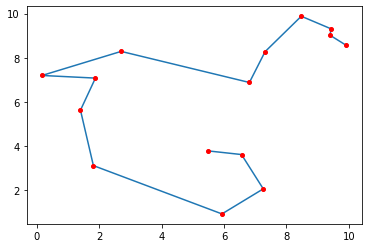

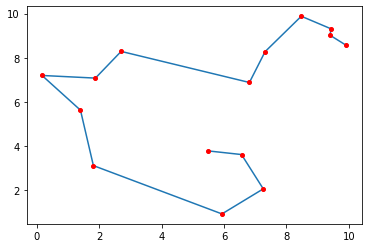

Optymalna permutacja:  (9, 1, 4, 13, 11, 0, 12, 2, 10, 7, 8, 3, 6, 5, 14)  
Długośc ścieżki : 26.820082909683528


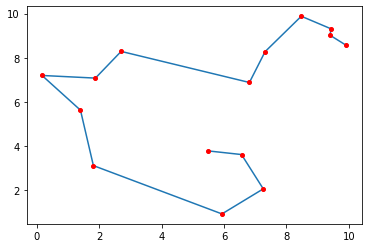

In [38]:
N = 15
X,Y = uniform_points(N,10,0,10,0)
visualize_points(X,Y)
print("Długośc ścieżki :", length(X,Y,N))
X2,Y2 = salesman_visualize(X,Y,N)
visualize_points(X2,Y2)

<b> Podsumowanie </b>

* Ważną różnicą pomiędzy pierwotnymi metodami iteracyjnymi, a algorytmem symulowanego wyżarzania jest możliwość wyboru przez niego gorszego rozwiązania. Wybór taki jest dokonywany z pewnym prawdopodobieństwem. Dzięki temu algorytm symulowanego wyżarzania może w określonych warunkach wyjść ze znalezionego minimum lokalnego i dalej podążać w kierunku rozwiązania optymalnego

* Parametrem algorytmu, który ma wpływ na prawdopodobieństwo wyboru gorszego rozwiązania jest parametr przeniesiony bezpośrednio z podstaw termodynamicznych algorytmu, czyli temperatura. Im wyższa, tym prawdopodobieństwo wyboru gorszego rozwiązania jest większe. Im niższa, tym algorytm jest bardziej zbliżony w działaniu do typowych metod iteracyjnych. To właśnie znajduje odzwierciedlenie w drugim ważnym aspekcie algorytmu symulowanego wyżarzania czyli w powolnym ochładzaniu.

* Na początku działania algorytmu temperatura jest wysoka, dzięki czemu algorytm może bardzo często zmieniać konfigurację rozwiązania, niejednokrotnie wybierając rozwiązanie gorsze. Wraz z kolejnymi iteracjami algorytmu temperatura spada i wybierane są częściej rozwiązania lepsze. Pod koniec pracy algorytmu, temperatura jest na tyle niska, że prawdopodobieństwo wyboru gorszego rozwiązania jest bliskie zeru. Algorytm zachowuje się wówczas, jak typowy algorytm iteracyjny i stara się maksymalnie ulepszyć rozwiązanie.



<b> Źródło podsumowania </b> <hr> [http://155.158.112.25/~algorytmyewolucyjne/materialy/algorytm_symulowanego_wyzarzania.pdf?fbclid=IwAR2OyacFqn8WZd2ecCsjRskspsbLZxkqDCJF-F6t8UidrGdTO-DMKpie8hk]